In [82]:
# Importing the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import re
import string



# Reading the data from the csv. 

Since the title of the article can contain important information or keywords about whether an article is fake or not, the first versions included the titles as well. However, the titles often contained the name of the source or other specific data that resulted in unneccessarily high accuracies. Since this can lead to decreased accuracy on a new dataset, the final decision was to remove the title.

In [83]:
df = pd.read_csv("data.csv")
df["content"] = df["text"]
# df['content'] = df['text'] + ' ' + df['title']
df.head()

,Unnamed: 0,title,text,label,content
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,No comment is expected from Barack Obama Membe...
1,1,NaN,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"Now, most of the demonstrators gathered last ..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,A dozen politically active pastors came here f...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"The RS-28 Sarmat missile, dubbed Satan 2, will..."


Removing null values

In [84]:
df.dropna(inplace=True)
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
content       0
dtype: int64

In [85]:
# This function removes the punctuations from the text
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

After manual inspection, certain changes had to be made to the dataset. Often the fake articles had the source (Reuters) or other words (in all capital) which altered the performace of the models. 

In [86]:
df['content'] = df['content'].str.replace('(Reuters) -', '')
df['content'] = df['content'].str.replace('-', ' ')
df['content'] = df['content'].apply(lambda x: re.sub(r'\b[A-Z]+\b', '', x))
df['content'] = df['content'].apply(lambda x: re.sub(r'http\S+|www\.\S+', '', x))

df["content"] = (
    df["content"]
    .str.lower()
    .apply(remove_punctuations)
)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/114adkiss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,title,text,label,content
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,no comment is expected from barack obama membe...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,now most of the demonstrators gathered last n...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came here fo...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,the 28 sarmat missile dubbed satan 2 will rep...
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,all we can say on this one is it s about time ...


The distribution of the labels are around equal, there is no need for synthetic data generation.

<Axes: xlabel='label'>

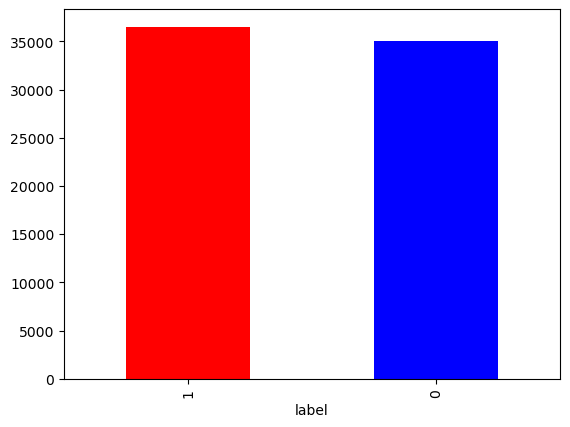

In [87]:
df['label'].value_counts().plot(kind='bar', color=["red", "blue"])


First the data is split into a train and test set, using a 80%-20% ratio. After, the texts are turned into vectors using the Tfidf vectorizer, so models can process them. 

In [88]:
texts = df['content']  
labels = df['label']  
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=0)

# Vectorizing the text
vectorizer = TfidfVectorizer(max_df=0.90, min_df=10, stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Applying models
## Naive Bayes

In [89]:
from sklearn.naive_bayes import MultinomialNB

# Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_nb = nb_model.predict(X_test_vec)
nb_scores = nb_model.predict_proba(X_test_vec)[:,1]
nb_classification_report = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))

Naive Bayes:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      6963
           1       0.83      0.86      0.84      7345

    accuracy                           0.84     14308
   macro avg       0.84      0.83      0.84     14308
weighted avg       0.84      0.84      0.84     14308



## Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression

# Training the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, C=0.1)
lr_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_lr = lr_model.predict(X_test_vec)
lr_scores = lr_model.predict_proba(X_test_vec)[:,1]
lr_classification_report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
print("Logistic regression:\n", classification_report(y_test, y_pred_lr))

Logistic regression:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      6963
           1       0.90      0.91      0.90      7345

    accuracy                           0.90     14308
   macro avg       0.90      0.90      0.90     14308
weighted avg       0.90      0.90      0.90     14308



## Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_model.fit(X_train_vec, y_train)

# Evaluating the model
y_pred_rf = rf_model.predict(X_test_vec)
rf_scores = rf_model.predict_proba(X_test_vec)[:,1]
rf_clasification_report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      6963
           1       0.86      0.90      0.88      7345

    accuracy                           0.88     14308
   macro avg       0.88      0.87      0.87     14308
weighted avg       0.88      0.88      0.88     14308



## XGBoost

In [92]:
import xgboost as xgb
# Train the XGBoost model
xgb_model = xgb.XGBClassifier(max_depth=4, n_estimators=100, reg_lambda=1.0)
xgb_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_vec)
xgb_scores = xgb_model.predict_proba(X_test_vec)[:,1]
xgb_classification_report = classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))


XGBoost:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      6963
           1       0.92      0.93      0.93      7345

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



## SVM

In [93]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Train the XGBoost model
svm_model = CalibratedClassifierCV(LinearSVC(), cv=5)
svm_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_svm = svm_model.predict(X_test_vec)
svm_scores = svm_model.predict_proba(X_test_vec)[:, 1]
svm_classification_report = classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)
print("SVM:\n", classification_report(y_test, y_pred_svm))

SVM:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      6963
           1       0.93      0.94      0.94      7345

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



# Comparing results
## Precision-Recall Curve

After accessing the results the following results have been found:
- SVM and XGBoost achieved the highest PRC_AUC scores with a score of 0.98.
- Closely behind Logistic regression and Random forest got 0.96 and 0.95.
- Finally Naive Bayes had the worst performance of 0.9.

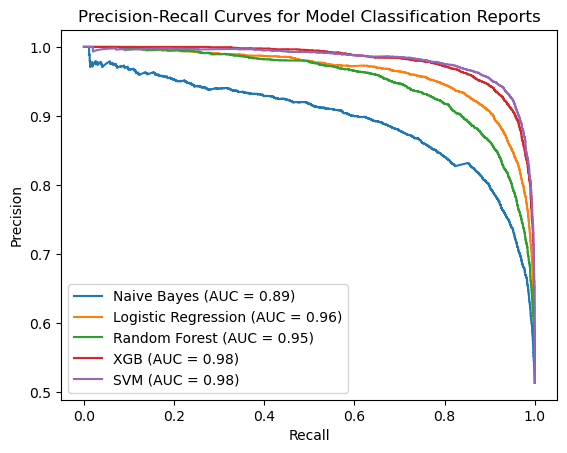

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate the precision-recall curves for each model
precision_nb, recall_nb, _ = precision_recall_curve(y_test, nb_scores)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_scores)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_scores)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_scores)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_scores)

# Calculate the area under the precision-recall curve for each model
auc_nb = auc(recall_nb, precision_nb)
auc_lr = auc(recall_lr, precision_lr)
auc_rf = auc(recall_rf, precision_rf)
auc_xgb = auc(recall_xgb, precision_xgb)
auc_svm = auc(recall_svm, precision_svm)

# Plot the precision-recall curves
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGB (AUC = {auc_xgb:.2f})')
plt.plot(recall_svm, precision_svm , label=f'SVM (AUC = {auc_svm:.2f})')

# Set the plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Model Classification Reports')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## ROC Curve

The ROC curves provided the following results:
- Similarly XGBoost and SVM had the best performance of all the models with a value of 0.98.
- Logistic regression and Random forest had similarly good performance with ROC AUC scores of 0.96 and 0.95.
- Finally Naive Bayes had the worst performance with a score of 0.91.

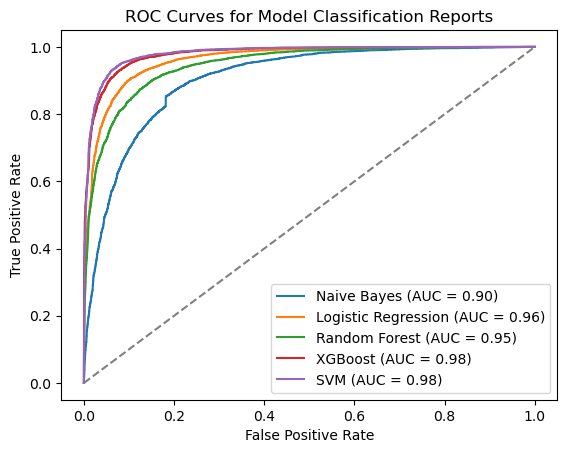

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curves for each model
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_scores)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_scores)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_scores)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_scores)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)

# Calculate the area under the ROC curve (AUC) for each model
roc_auc_nb = auc(fpr_nb, tpr_nb)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curves
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set the plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Model Classification Reports')

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Accuracies

In terms of accuracy, the accuracy table has shown that the SVM model had the best performance.

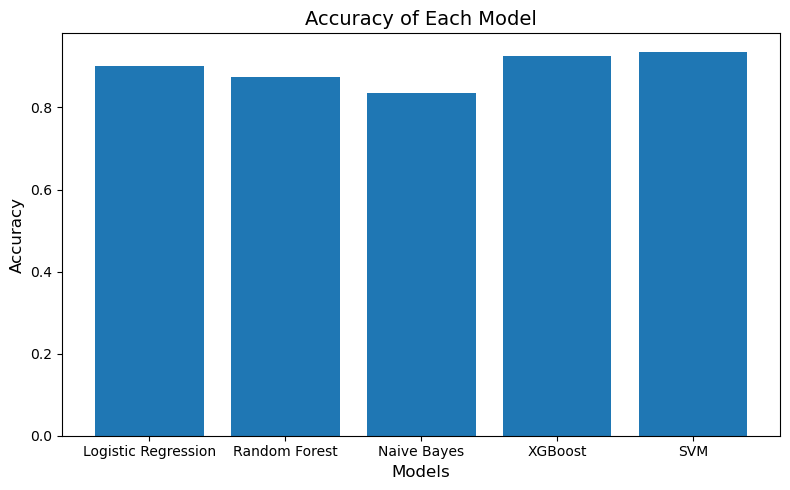

In [96]:
import matplotlib.pyplot as plt

# Example accuracies (use the actual ones you've calculated)
accuracies = {
    "Logistic Regression": lr_classification_report["accuracy"],
    "Random Forest": rf_clasification_report["accuracy"],
    "Naive Bayes": nb_classification_report["accuracy"],
    "XGBoost": xgb_classification_report["accuracy"],
    "SVM": svm_classification_report["accuracy"],
}

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(accuracies.keys(), accuracies.values())

# Customizing the plot
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy of Each Model", fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

The results were suspiciously good, so some tests had to be made, to make sure the method is valid.

## Manual Inspection of Records

During manual inspection of the dataset, several records contained misleading text parts. Some entries in the `content` field included names of journals, publishers, or other proper nouns written entirely in uppercase letters, such as 'REUTERS'.

These capitalized phrases are not informative for the classification task (e.g., fake news detection) and may introduce bias into the model, especially if certain sources disproportionately appear in one class.



To clean the data, we decided to remove these uppercase-only names from the `content`. This will help ensure that the model focuses on the actual textual content of the articles rather than overfitting to specific source names.



In [97]:
print(df[df['label'] == 0].iloc[1000]['content'])


  conservative radio talk show host laura ingraham said on sunday she is being considered by president elect donald trump to serve as white house press secretary ingraham said she has talked to trump and she was privileged to be considered “it’s an intriguing idea” she said on “fox news sunday” ingraham defended the trump transition team’s decision not to include a pool of reporters when he has traveled at times she said the news media had been “stacking the deck against trump” before the election   


In [98]:
print(df[df['label'] == 1].iloc[5000]['content'])


what a shame daily news went on to criticize president trump for treating his visit like a campaign stop and for praising the excellent job governor abbott has done thus far they also criticized him for acknowledging his  director william brock long suggesting he s  a man who s really become very famous on television in the last couple of days  trump continued  we appreciate it very much you have been just outstanding  trump told longpresident trump traveled to corpus christie  to reassure the victims of hurricane harvey that the federal state and local governments are doing all that they can to restore their homes and their lives following the most devastating storm in texas  historyhere s part of what he had to say to the large crowdas  realdonaldtrump has said   the  of  is absolutely incredible       texasstrong pictwittercomyivhrotrdl  dan scavino jr scavino45 august 29 2017massive crowds outside trump briefing in corpus christi on harvey relief efforts  pictwittercomlhh4eqqhe7   

## Sanity Check

In order to make sure that the models work well we performed sanity checks on them. In the first check a DummyClassifier was imported and configured to predict the most frequent values. Since the dataset had around a 1:1 ratio for the labels the accuracy is not surprising. The second check consissted of shuffling the labels to ensure the model works as expected. The low outcome scores suggest that everything works as expected.


In [99]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_vec, y_train)
print("Baseline accuracy:", dummy.score(X_test_vec, y_test))


Baseline accuracy: 0.513349175286553


In [100]:
import numpy as np
y_train_shuffled = np.random.permutation(y_train)
svm_model.fit(X_train_vec, y_train_shuffled)
y_pred_dummy = xgb_model.predict(X_test_vec)
print(classification_report(y_test, y_pred_dummy))


              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6963
           1       0.92      0.93      0.93      7345

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



** Inspecting significant words

To gain insight into what the SVM model has learned, we examined the model's coefficients to identify the most influential words for predicting the positive class. Most of them seem completely normal, except for `http`. As a result all links were removed from the dataset. 


In [101]:
calibrated_models = svm_model.calibrated_classifiers_

linear_svc_model = calibrated_models[0].estimator
coefs = linear_svc_model.coef_.flatten()

top_indices = np.argsort(coefs)[-20:]
feature_names = vectorizer.get_feature_names_out()
top_words = [feature_names[i] for i in top_indices]

print("Top predictive words for the positive class:")
print(top_words)


Top predictive words for the positive class:
['lobby', 'diseases', 'delayed', 'investments', 'formal', 'getty', 'evangelical', 'contributions', 'countless', 'update', 'formed', 'troubled', 'scrutiny', 'aspect', 'lights', 'teaching', 'proving', 'sharp', 'surprisingly', 'larry']
